<a href="https://colab.research.google.com/github/khaqan-ashraf/msds19019_COVID19_DLSpring2020/blob/master/covid19_classification_focal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import torch.nn.functional as func
import os
import pandas as pd

In [2]:

from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/DeepLearning/covid_dataset.zip" -d "./gdrive/My Drive/DeepLearning"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
DATADIR = './gdrive/My Drive/DeepLearning/A_05_Part_02_Dataset'
# DATADIR = '/content/gdrive/My Drive/Copy of Assignment 5 Dataset'


In [77]:
batch_size = 50
Datatransforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                     ])

mtransforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.517, 0.517, 0.517],
                                                            [0.21, 0.21, 0.21])])

#pass transform here-in
train_data = datasets.ImageFolder(DATADIR + '/Train', transform=Datatransforms)
test_data = datasets.ImageFolder(DATADIR + '/Test', transform=Datatransforms)
validation_data = datasets.ImageFolder(DATADIR + '/Validation', transform=Datatransforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
000000000000000000
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

In [22]:

inputs, classes = next(iter(trainloader))
inputs.shape, classes.shape

(torch.Size([50, 3, 224, 224]), torch.Size([50]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


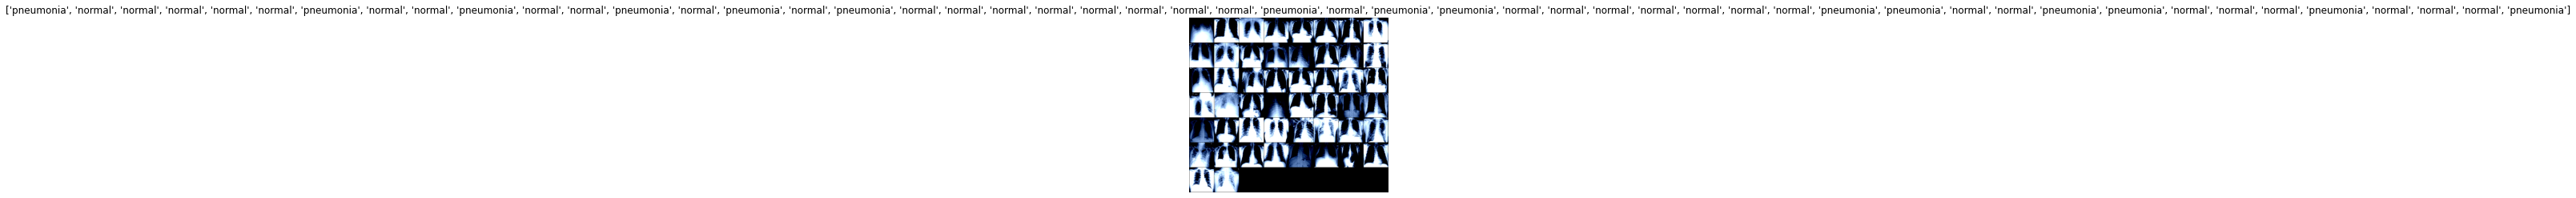

In [23]:
show_databatch(inputs, classes)

In [0]:

inputs, classes = next(iter(validationloader))
inputs.shape, classes.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


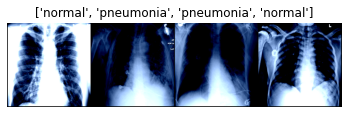

In [0]:
show_databatch(inputs, classes)

In [0]:
def one_hot_encoding(labels):
    labels = labels.reshape(labels.size()[0], 1)
    one_hot =  (labels == torch.arange(3)).float()
    one_hot[:, 2] = one_hot[:, 0]+one_hot[:, 2]
    return one_hot

In [25]:
# device = "cuda:0"
# one_hot = one_hot_encoding(torch.tensor([1,0,2,1]))
# one_hot
one_hot_encoding(classes)

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0

In [0]:
def train(model, trainloader, validationloader,  optimizer, critarion, epochs, datadir,  model_name):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
   
    print('Device: ', device)

    model.to(device)
    model.train()
    loss_curve = list()
    acc_curve = list()
    valid_loss_curve = list()
    valid_acc_curve = list()
    for epoch in range(epochs):
        # print('Epoch: ', epoch)
        running_loss = 0.0
        total = 0
        correct = 0
        valid_total = 0
        valid_correct = 0
        valid_loss = 0.0
        
        for i, data in tqdm(enumerate(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # inputs, labels = inputs.cuda(), labels.cuda()
            target = one_hot_encoding(labels).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = critarion(outputs, target)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            running_loss += loss.item()

            # print('\t[', loss.item(), '\\', correct/total*100, ']')
            # if i ==10:
            #   break


        

        for j, data in tqdm(enumerate(validationloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            targets = one_hot_encoding(labels).to(device)
            outputs = model(inputs)
            loss = critarion(outputs, targets)
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted==labels).sum().item()
            valid_loss += loss.item()
            # print('\t[', loss.item(), '\\', valid_correct/valid_total*100, ']')
            # if j==10:
            #   break
        

        epoch_valid_loss = valid_loss/len(validationloader)
        epoch_valid_acc = valid_correct/valid_total*100
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = correct / total*100
        # print('\tTraining Loss: ', epoch_loss, '\tTraining Accuracy: ', epoch_acc)
        print('Epoch: ', epoch,'\tTraining Loss: ', epoch_loss, '\tTraining Accuracy: ', epoch_acc, '\tValidation Loss: ', epoch_valid_loss, '\tValidation Accuracy: ', epoch_valid_acc)

        loss_curve.append(epoch_loss)
        acc_curve.append(epoch_acc)
        valid_loss_curve.append(epoch_valid_loss)
        valid_acc_curve.append(epoch_valid_acc)

        
        torch.save(model.state_dict(), datadir + '/' + model_name)
        history = {'loss_curve': loss_curve,
                   'acc_curve': acc_curve,
                   'valid_loss_curve': valid_loss_curve,
                   'valid_acc_curve': valid_acc_curve}
        torch.save(history, datadir + '/history_' + model_name)

        

    return loss_curve, acc_curve, valid_loss_curve, valid_acc_curve


In [0]:
def predict(model, validationloader, critarion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print('Device: ', device)

    train_predictions, train_labels = list(), list()
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
      for i, data in tqdm(enumerate(trainloader)):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          targets = one_hot_encoding(labels).to(device)
          outputs = model(inputs)
          loss = critarion(outputs, targets)

          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted==labels).sum().item()
          running_loss += loss.item()

          train_predictions.extend(list(labels.numpy()))
          train_labels.extend(list(predicted.numpy()))

      cal_loss = running_loss / len(trainloader)
      cal_acc = correct / total

      print('Loss: ', cal_loss, '\tAccuracy: ', cal_acc)


    return confusion_matrix(train_labels, train_predictions)

In [13]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [14]:
num_features = resnet18.fc.in_features
fc = [
      nn.Linear(num_features, 1000),
      nn.ReLU(),
      nn.Linear(1000, 500),
      nn.ReLU(),
      nn.Linear(500, len(train_data.classes)),
      nn.Sigmoid()
]

fc

[Linear(in_features=512, out_features=1000, bias=True),
 ReLU(),
 Linear(in_features=1000, out_features=500, bias=True),
 ReLU(),
 Linear(in_features=500, out_features=3, bias=True),
 Sigmoid()]

In [15]:
resnet18.fc = nn.Sequential(*fc)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet18.parameters():
    param.requires_grad = False

In [0]:
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [18]:
for param in resnet18.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [19]:
name = 'resnet18_simple.pth'
epochs = 20
critarion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
loss_curve, acc_curve, valid_loss_curve, valid_acc_curve = train(resnet18, trainloader, validationloader, optimizer, critarion, epochs, DATADIR, name)

0it [00:00, ?it/s]

Device:  cpu


6200it [1:03:33,  1.63it/s]
628it [06:23,  1.64it/s]


Epoch:  0 	Training Loss:  0.6812932017733974 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.6838568487934246 	Validation Accuracy:  63.69426751592356


6200it [14:04,  7.34it/s]
628it [01:20,  7.82it/s]
0it [00:00, ?it/s]

Epoch:  1 	Training Loss:  0.6797976157165343 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.6847238102156645 	Validation Accuracy:  63.69426751592356


6200it [14:01,  7.37it/s]
628it [01:20,  7.77it/s]
0it [00:00, ?it/s]

Epoch:  2 	Training Loss:  0.6798523749939857 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.680984434618312 	Validation Accuracy:  63.69426751592356


6200it [14:09,  7.30it/s]
628it [01:21,  7.71it/s]


Epoch:  3 	Training Loss:  0.6796591246608765 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.6808044426380448 	Validation Accuracy:  63.69426751592356


6200it [14:19,  7.22it/s]
628it [01:22,  7.64it/s]
0it [00:00, ?it/s]

Epoch:  4 	Training Loss:  0.6793724491230904 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.6809125105097036 	Validation Accuracy:  63.69426751592356


6200it [14:22,  7.19it/s]
628it [01:21,  7.67it/s]


Epoch:  5 	Training Loss:  0.6796026627959744 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.6812226457200992 	Validation Accuracy:  63.69426751592356


6200it [14:17,  7.23it/s]
628it [01:22,  7.65it/s]
0it [00:00, ?it/s]

Epoch:  6 	Training Loss:  0.6794239051976512 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.6805434431999352 	Validation Accuracy:  63.69426751592356


6200it [14:22,  7.18it/s]
628it [01:22,  7.61it/s]
0it [00:00, ?it/s]

Epoch:  7 	Training Loss:  0.6792881650886228 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.6804737901421869 	Validation Accuracy:  63.69426751592356


6200it [14:29,  7.13it/s]
628it [01:22,  7.62it/s]
0it [00:00, ?it/s]

Epoch:  8 	Training Loss:  0.6792436864972115 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.6814362128638918 	Validation Accuracy:  63.69426751592356


6200it [14:33,  7.10it/s]
628it [01:22,  7.58it/s]
0it [00:00, ?it/s]

Epoch:  9 	Training Loss:  0.6794366557559659 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.6804571892994984 	Validation Accuracy:  63.69426751592356


6200it [14:30,  7.12it/s]
628it [01:22,  7.64it/s]
0it [00:00, ?it/s]

Epoch:  10 	Training Loss:  0.6791319013314863 	Training Accuracy:  64.51612903225806 	Validation Loss:  0.680511200219203 	Validation Accuracy:  63.69426751592356


4980it [11:40,  7.08it/s]

Buffered data was truncated after reaching the output size limit.

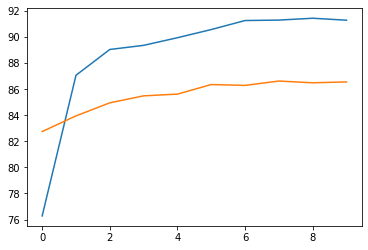

In [153]:
plt.plot(range(len(acc_curve)), acc_curve)
plt.plot(range(len(valid_acc_curve)), valid_acc_curve)


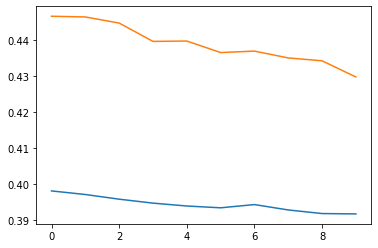

In [154]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(valid_loss_curve)), valid_loss_curve)


In [135]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [141]:
vgg16.classifier[0]

Linear(in_features=25088, out_features=4096, bias=True)

In [142]:
num_features = vgg16.classifier[0].in_features
fc = [
      nn.Linear(num_features, 1000),
      nn.ReLU(),
      nn.Linear(1000, 500),
      nn.ReLU(),
      nn.Linear(500, len(train_data.classes)),
      nn.Sigmoid()
]

fc

[Linear(in_features=25088, out_features=1000, bias=True),
 ReLU(),
 Linear(in_features=1000, out_features=500, bias=True),
 ReLU(),
 Linear(in_features=500, out_features=3, bias=True),
 Sigmoid()]

In [143]:
vgg16.classifier = nn.Sequential(*fc)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for param in vgg16.parameters():
    param.requires_grad = False

In [0]:
for param in vgg16.classifier.parameters():
    param.requires_grad = True

In [0]:
name = 'vgg16_simple.pth'
epochs = 20
critarion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)
loss_curve, acc_curve, valid_loss_curve, valid_acc_curve = train(vgg16, trainloader, validationloader, optimizer, critarion, epochs, DATADIR, name)

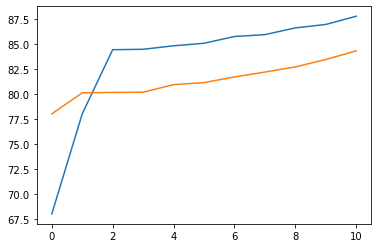

In [149]:
plt.plot(range(len(acc_curve)), acc_curve)
plt.plot(range(len(valid_acc_curve)), valid_acc_curve)


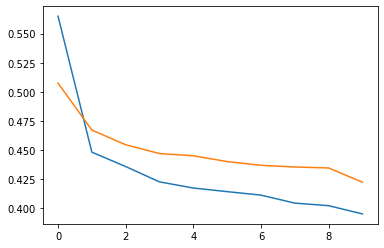

In [150]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(valid_loss_curve)), valid_loss_curve)


 Required Classes:  infected, normal


In [0]:
class floss(nn.Module):
    def __init__(self, alpha=1, gamma=1.2):
        super(floss,self).__init__()
        self.a = alpha
        self.g = gamma
        
    def forward(self, outputs, labels):
        bce = func.binary_cross_entropy_with_logits(outputs, labels)
        pt = torch.exp(-bce)
        loss = self.a * ((1-pt)**self.g) * bce
        return loss.mean()

In [0]:
name = 'resnet18_focal_loss.pth'
epochs = 20
critarion = floss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
loss_curve, acc_curve, valid_loss_curve, valid_acc_curve = train(resnet18, trainloader, validationloader, optimizer, critarion, epochs, DATADIR, name)

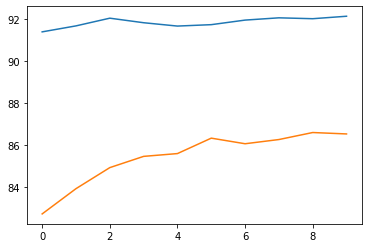

In [156]:
plt.plot(range(len(acc_curve)), acc_curve)
plt.plot(range(len(valid_acc_curve)), valid_acc_curve)


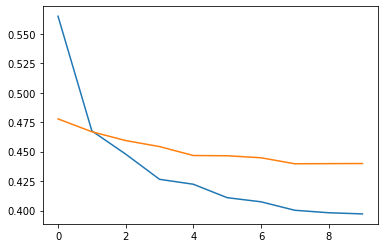

In [158]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(valid_loss_curve)), valid_loss_curve)


In [0]:
name = 'vgg16_focal_loss.pth'
epochs = 20
critarion = floss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)
loss_curve, acc_curve, valid_loss_curve, valid_acc_curve = train(vgg16, trainloader, validationloader, optimizer, critarion, epochs, DATADIR, name)

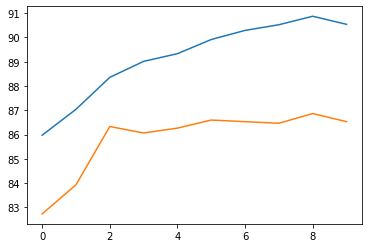

In [160]:
plt.plot(range(len(acc_curve)), acc_curve)
plt.plot(range(len(valid_acc_curve)), valid_acc_curve)


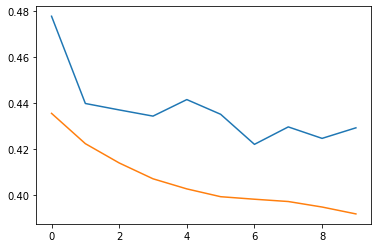

In [162]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(valid_loss_curve)), valid_loss_curve)


In [96]:
model = resnet18
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Device: ', device)

train_predictions, train_labels = list(), list()
running_loss = 0.0
total = 0
correct = 0
predictions = list()
with torch.no_grad():
  for i, data in tqdm(enumerate(testloader)):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      
      outputs = model(inputs)
      
      pred = torch.sigmoid(outputs)
      predictions.extend(pred.numpy()>0.5)
      # print(predictions)





































0it [00:00, ?it/s]

Device:  cpu






































1it [00:03,  3.95s/it]



































2it [00:07,  3.96s/it]



































3it [00:11,  3.96s/it]



































4it [00:15,  3.99s/it]



































5it [00:19,  3.97s/it]



































6it [00:23,  3.96s/it]



































7it [00:27,  3.95s/it]



































8it [00:31,  3.95s/it]



































9it [00:35,  3.95s/it]



































10it [00:39,  3.94s/it]



































11it [00:43,  3.94s/it]



































12it [00:47,  3.95s/it]



































13it [00:51,  3.95s/it]



































14it [00:55,  3.95s/it]



































15it [00:59,  3.95s/it]



































16it [01:03,  3.95s/it]



































17it [01:07,  3.95s/it]







In [99]:
labels = np.array(predictions)
labels.shape

(629, 3)

In [106]:
predicted_labels = labels*1
predicted_labels

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 1],
       [0, 1, 0]])

In [0]:
new_predicted_labels = predicted_labels.copy()

In [0]:
new_predicted_labels[:, 1] = predicted_labels[:, 2]
new_predicted_labels[:, 2] = predicted_labels[:, 1]


In [122]:
new_predicted_labels

array([[0, 0, 1],
       [0, 1, 0],
       [1, 1, 0],
       ...,
       [0, 1, 0],
       [1, 1, 0],
       [0, 0, 1]])

In [0]:
names = []
for file in os.listdir(DATADIR+"/Test/unlabeled"):
    names.append(file)
names = np.array(names).reshape(len(names),1)

In [127]:
names

array([['437.jpg'],
       ['105.jpg'],
       ['266.jpg'],
       ['594.jpg'],
       ['208.png'],
       ['283.png'],
       ['586.jpg'],
       ['178.jpg'],
       ['9.jpg'],
       ['313.png'],
       ['229.jpg'],
       ['492.png'],
       ['415.jpg'],
       ['410.jpg'],
       ['19.png'],
       ['533.jpg'],
       ['605.jpg'],
       ['474.jpg'],
       ['104.jpg'],
       ['230.jpg'],
       ['609.jpg'],
       ['214.jpg'],
       ['39.jpg'],
       ['527.jpg'],
       ['149.jpg'],
       ['323.jpg'],
       ['28.png'],
       ['512.jpg'],
       ['524.jpg'],
       ['62.png'],
       ['11.png'],
       ['200.png'],
       ['312.png'],
       ['421.png'],
       ['222.png'],
       ['339.png'],
       ['67.png'],
       ['55.png'],
       ['509.png'],
       ['176.png'],
       ['238.png'],
       ['72.png'],
       ['205.png'],
       ['578.png'],
       ['355.png'],
       ['562.png'],
       ['233.png'],
       ['77.png'],
       ['407.png'],
       ['420.png'],
       ['20

In [0]:
result = np.hstack((names, new_predicted_labels))

In [131]:
pd.DataFrame(result)

,0,1,2,3
0,437.jpg,0,0,1
1,105.jpg,0,1,0
2,266.jpg,1,1,0
3,594.jpg,0,1,0
4,208.png,0,0,0
...,...,...,...,...
624,563.png,0,1,0
625,488.png,0,0,1
626,593.png,0,1,0
627,90.png,1,1,0


In [0]:
torch.save(result, './gdrive/My Drive/DeepLearning/result.pth')

In [134]:
torch.load('./gdrive/My Drive/DeepLearning/result.pth')

array([['437.jpg', '0', '0', '1'],
       ['105.jpg', '0', '1', '0'],
       ['266.jpg', '1', '1', '0'],
       ...,
       ['593.png', '0', '1', '0'],
       ['90.png', '1', '1', '0'],
       ['15.png', '0', '0', '1']], dtype='<U21')